**NOTE** This notebook gives us statistics on the annotated data.

In [1]:
import json
from collections import defaultdict
import csv

### 1. Setup job ID and load the results JSONL file

In [2]:
job_ids=["1285337", "1286025"]
data_loc='crowd_data'

results=[]
for jid in job_ids:
    filename='%s/job_%s.json' % (data_loc, jid)
    with open(filename, 'r') as f:
        for line in f:
            results.append(json.loads(line))

len(results)

338

### 2. Get basic stats

In [3]:
states_count=defaultdict(int)
for result in results:
    states_count[result['state']]+=1
states_count

defaultdict(int, {'finalized': 305, 'golden': 23, 'hidden_gold': 10})

### 4. Parse and format 'real' data

In [4]:
def get_judgements_distribution(judgements, prop):
    dists=defaultdict(int)
    for j in judgements:
        for value in j['data'][prop]:
            dists[value]+=1
    for k,v in dists.items():
        dists[k]=round(v/len(judgements), 2)
    return dict(dists)

In [5]:
all_props=['century', 'religion', 'gender', 'deathplace', 'lifedur', 'birthplace',
      'worklocation', 'occupation', 'educatedat', 'politicalparty'] #[::-1]
only_top_result=True

predict_high_entropy=True
    
known_attr_to_undecided = {}
value_dist_per_prop = {}
dominant_class_prob = {}

if predict_high_entropy:
    props=all_props[3:]
else:
    props=all_props[:-3]
print(props)
for p in props:
    known_attr_to_undecided[p] = defaultdict(list)
    value_dist_per_prop[p] = defaultdict(list)
    dominant_class_prob[p] = defaultdict(list)
    
undecided='I can not decide' 

cases = defaultdict(int)

for result in results:
    if result['state'] in ['finalized', 'judgable']:
        this_data=result['data']
        these_judgements=result['results']['judgments']
        this_id=result['id']
        known_props=0
        if predict_high_entropy and this_data['politicalparty']: continue # to skip the low-to-high entropy
        if not predict_high_entropy and this_data['century']: continue
        for k in all_props:
            v=this_data[k]
            if v and v!='NOFILL':
                known_props+=1
        for k in all_props:
            v=this_data[k]
            if not v:
                cases[k]+=1
                dist=get_judgements_distribution(these_judgements, 'sel%s' % k)
                if undecided in dist.keys():
                    known_attr_to_undecided[k][known_props].append(dist[undecided])
                else:
                    known_attr_to_undecided[k][known_props].append(0.0)
                for prop_val, prop_val_prob in dist.items():
                    value_dist_per_prop[k][prop_val].append(prop_val_prob)
                    
                max_value=0.0
                for prop_val, prop_val_prob in dist.items():
                    if prop_val!=undecided and prop_val_prob>max_value:
                        max_value=prop_val_prob
                dominant_class_prob[k][known_props].append(max_value)

['deathplace', 'lifedur', 'birthplace', 'worklocation', 'occupation', 'educatedat', 'politicalparty']


In [6]:
value_dist_per_prop

{'birthplace': defaultdict(list,
             {'Boston (MA)': [0.12,
               0.13,
               0.07,
               0.6,
               0.53,
               0.13,
               0.67,
               0.4,
               0.13,
               0.07,
               0.07,
               0.06,
               0.13,
               0.07,
               0.2,
               0.07,
               0.07,
               0.67,
               0.53,
               0.07,
               0.07,
               0.07,
               0.07,
               0.13,
               0.07,
               0.07,
               0.07,
               0.07,
               0.07,
               0.07,
               0.13,
               0.07,
               0.07,
               0.07,
               0.2,
               0.87,
               0.07],
              'Chicago (IL)': [0.06,
               0.07,
               0.07,
               0.07,
               0.07,
               0.07,
               0.13,
               

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

deathplace 3 0.49583333333333335
lifedur 3 0.27666666666666667
lifedur 4 0.18485714285714291
birthplace 3 0.47500000000000003
birthplace 4 0.18485714285714291
birthplace 5 0.15800000000000008
worklocation 3 0.4808333333333333
worklocation 4 0.19171428571428575
worklocation 5 0.13800000000000012
worklocation 6 0.07833333333333332
occupation 3 0.4300000000000001
occupation 4 0.35742857142857143
occupation 5 0.2939999999999998
occupation 6 0.2898484848484848
occupation 7 0.17666666666666667
educatedat 3 0.5183333333333334
educatedat 4 0.3814285714285714
educatedat 5 0.33538461538461495
educatedat 6 0.2930303030303028
educatedat 7 0.24666666666666667
educatedat 8 0.19666666666666668
politicalparty 3 0.30333333333333334
politicalparty 4 0.13714285714285712
politicalparty 5 0.1392307692307693
politicalparty 6 0.10909090909090906
politicalparty 7 0.11333333333333336
politicalparty 8 0.045000000000000005


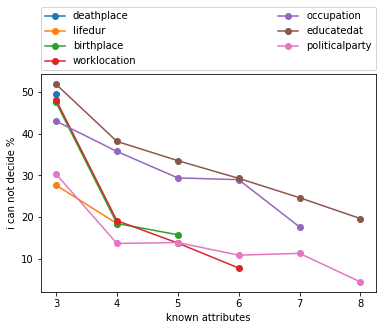

In [8]:
fig = plt.figure()

cutoff=10
for prop, data in known_attr_to_undecided.items():
    x=[]
    y=[]
    for known_attr in range(3,9):
        if not data[known_attr]: continue
        perc=data[known_attr]
        if known_attr>cutoff: continue
        print(prop, known_attr, sum(perc)/len(perc))
        x.append(known_attr)
        y.append(sum(perc)*100/len(perc))
    plt.plot(x,y, '-o', label=prop)
plt.ylabel('i can not decide %')
plt.xlabel('known attributes')
lgd=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
fig.savefig('img/uncertainties_cutoff%d.png' % cutoff, bbox_extra_artists=(lgd,), bbox_inches='tight')

deathplace 3 0.24833333333333332
lifedur 3 0.28750000000000003
lifedur 4 0.3557142857142857
birthplace 3 0.2533333333333333
birthplace 4 0.6454285714285716
birthplace 5 0.6573846153846155
worklocation 3 0.2875
worklocation 4 0.5597142857142858
worklocation 5 0.6584615384615382
worklocation 6 0.6960606060606058
occupation 3 0.24916666666666668
occupation 4 0.2985714285714286
occupation 5 0.3386153846153845
occupation 6 0.32348484848484826
occupation 7 0.5366666666666667
educatedat 3 0.1991666666666667
educatedat 4 0.28000000000000014
educatedat 5 0.30815384615384606
educatedat 6 0.3134848484848483
educatedat 7 0.41
educatedat 8 0.3516666666666666
politicalparty 3 0.4775
politicalparty 4 0.6240000000000002
politicalparty 5 0.6116923076923079
politicalparty 6 0.6248484848484851
politicalparty 7 0.5666666666666668
politicalparty 8 0.6583333333333333


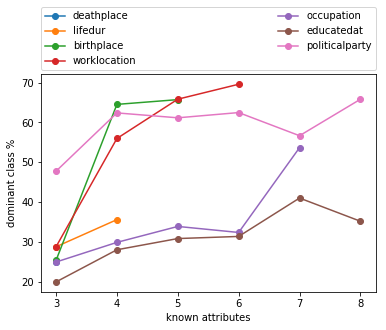

In [9]:
fig = plt.figure()
cutoff = 10
for prop, data in dominant_class_prob.items():
    x=[]
    y=[]
    for known_attr in range(3,9):
        if not data[known_attr]: continue
        perc=data[known_attr]
        if known_attr>cutoff: continue
        print(prop, known_attr, sum(perc)/len(perc))
        x.append(known_attr)
        y.append(sum(perc)*100/len(perc))
    plt.plot(x, y, '-o', label=prop)
plt.ylabel('dominant class %')
plt.xlabel('known attributes')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
fig.savefig('img/dominantclass_cutoff%d.png' % cutoff, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [10]:
for prop, data in value_dist_per_prop.items():
    for prop_val, perc in data.items():
        print(prop, prop_val, sum(perc)/cases[prop])

deathplace Boston (MA) 0.06583333333333334
deathplace I can not decide 0.49583333333333335
deathplace New York City (NY) 0.1991666666666667
deathplace San Francisco (CA) 0.05083333333333334
deathplace Los Angeles (CA) 0.03416666666666667
deathplace None of the above 0.022500000000000003
deathplace Philadelphia (PA) 0.0175
deathplace Chicago (IL) 0.03333333333333333
deathplace Washington D.C. 0.06666666666666667
deathplace Santa Monica (CA) 0.0175
lifedur 51-60 0.09553191489361702
lifedur 31-40 0.021702127659574477
lifedur 61-70 0.22212765957446806
lifedur 41-50 0.047234042553191496
lifedur 81-90 0.0753191489361702
lifedur I can not decide 0.2082978723404255
lifedur 71-80 0.30680851063829784
lifedur 101-110 0.005957446808510639
lifedur 91-100 0.008936170212765958
lifedur 21-30 0.00851063829787234
lifedur None of the above 0.0014893617021276596
birthplace Boston (MA) 0.06276785714285718
birthplace I can not decide 0.2003571428571427
birthplace Philadelphia (PA) 0.09508928571428575
birthp

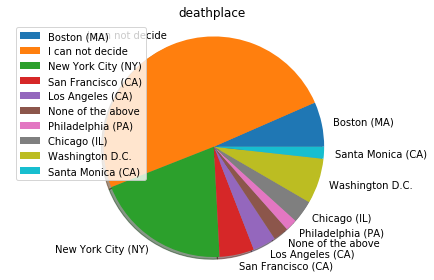

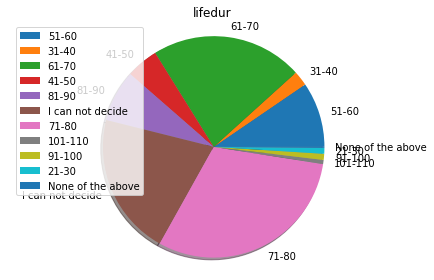

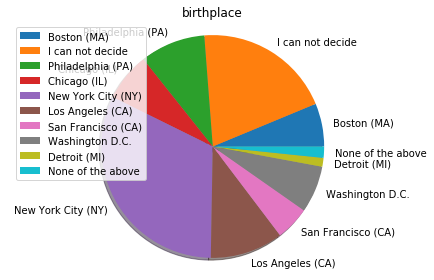

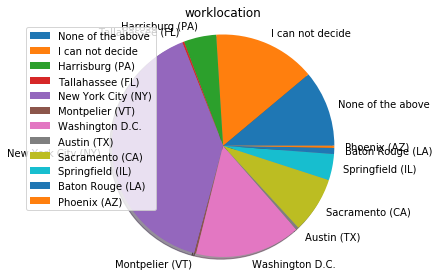

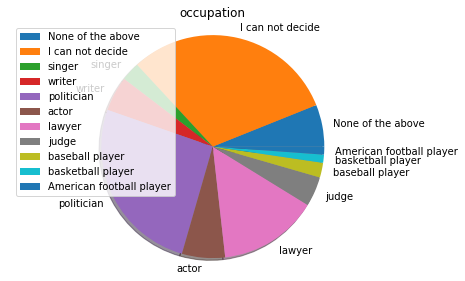

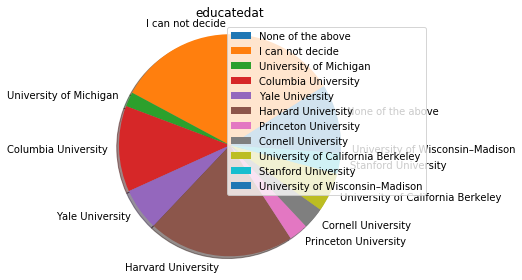

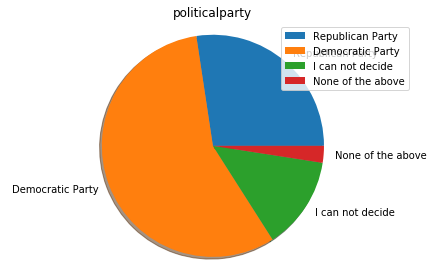

In [13]:
for prop, data in value_dist_per_prop.items():
    fig = plt.figure()
    
    labels=[]
    sizes=[]

    for prop_val, perc in data.items():
        sizes.append(sum(perc)/cases[prop])
        labels.append(prop_val)
    patches, texts = plt.pie(sizes, labels=labels, shadow=True)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(prop)
    plt.legend(patches, labels, loc="best")
    plt.tight_layout()
    #break
    if predict_high_entropy:
        fig.savefig('img/high/%s_values.png' % prop)
    else:
        fig.savefig('img/low/%s_values.png' % prop)

    


In [12]:
cases

defaultdict(int,
            {'birthplace': 112,
             'deathplace': 12,
             'educatedat': 190,
             'lifedur': 47,
             'occupation': 184,
             'politicalparty': 191,
             'worklocation': 178})